# Notebook A: Stablecoin Risk Scoring & Depeg Analysis

## Learning Objectives
- Build quantitative risk scoring model for stablecoins
- Analyze historical depeg events and arbitrage opportunities
- Perform time series analysis of stablecoin price stability
- Visualize risk metrics across different stablecoin mechanisms

---

## 1. Setup and Imports

In [17]:
# Import essential libraries
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from typing import Dict, List, Tuple
import warnings
import time
from scipy import stats

warnings.filterwarnings('ignore')

# Configure visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
%matplotlib inline

# Pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.6f}'.format)

print("[SUCCESS] All libraries imported successfully")
print(f"Session started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

[SUCCESS] All libraries imported successfully
Session started: 2025-11-02 13:55:15


## 2. API Configuration and Helper Functions

In [18]:
# API Configuration
COINGECKO_API = 'https://api.coingecko.com/api/v3'

# Helper function for API calls with exponential backoff
def fetch_api(url: str, params: Dict = None, max_retries: int = 3) -> Dict:
    """
    Fetch data from API with error handling, rate limiting, and exponential backoff.
    
    Args:
        url: API endpoint
        params: Query parameters
        max_retries: Maximum number of retry attempts
    
    Returns:
        JSON response as dictionary
    """
    for attempt in range(max_retries):
        try:
            time.sleep(1.5 * (attempt + 1))  # Exponential backoff
            response = requests.get(url, params=params, timeout=30)
            response.raise_for_status()
            return response.json()
        except requests.exceptions.HTTPError as e:
            if e.response.status_code == 429:  # Rate limit
                wait_time = 10 * (attempt + 1)
                print(f"[WARNING] Rate limited. Waiting {wait_time}s...")
                time.sleep(wait_time)
            else:
                print(f"[ERROR] HTTP Error: {e}")
                return None
        except Exception as e:
            print(f"[ERROR] API Error (attempt {attempt + 1}/{max_retries}): {e}")
            if attempt == max_retries - 1:
                return None
    return None

print("[SUCCESS] API configuration complete")

[SUCCESS] API configuration complete


## 3. Stablecoin Universe Definition

In [19]:
# Define comprehensive stablecoin universe with metadata
STABLECOINS = [
    # Fiat-Backed Stablecoins
    {
        'id': 'tether',
        'symbol': 'USDT',
        'name': 'Tether',
        'mechanism': 'Fiat-Backed',
        'issuer': 'Tether Limited',
        'transparency_score': 6,  # 0-10 scale
        'regulatory_status': 'Under scrutiny',
        'launch_year': 2014
    },
    {
        'id': 'usd-coin',
        'symbol': 'USDC',
        'name': 'USD Coin',
        'mechanism': 'Fiat-Backed',
        'issuer': 'Circle',
        'transparency_score': 9,
        'regulatory_status': 'Regulated (US)',
        'launch_year': 2018
    },
    {
        'id': 'binance-usd',
        'symbol': 'BUSD',
        'name': 'Binance USD',
        'mechanism': 'Fiat-Backed',
        'issuer': 'Paxos',
        'transparency_score': 8,
        'regulatory_status': 'Phased out (2023)',
        'launch_year': 2019
    },
    {
        'id': 'true-usd',
        'symbol': 'TUSD',
        'name': 'TrueUSD',
        'mechanism': 'Fiat-Backed',
        'issuer': 'TrustToken',
        'transparency_score': 8,
        'regulatory_status': 'Regulated',
        'launch_year': 2018
    },
    {
        'id': 'first-digital-usd',
        'symbol': 'FDUSD',
        'name': 'First Digital USD',
        'mechanism': 'Fiat-Backed',
        'issuer': 'First Digital Labs',
        'transparency_score': 7,
        'regulatory_status': 'Hong Kong regulated',
        'launch_year': 2023
    },
    
    # Crypto-Collateralized Stablecoins
    {
        'id': 'dai',
        'symbol': 'DAI',
        'name': 'Dai',
        'mechanism': 'Crypto-Collateralized',
        'issuer': 'MakerDAO',
        'transparency_score': 10,  # Fully on-chain
        'regulatory_status': 'Decentralized',
        'launch_year': 2017
    },
    {
        'id': 'frax',
        'symbol': 'FRAX',
        'name': 'Frax',
        'mechanism': 'Hybrid',
        'issuer': 'Frax Finance',
        'transparency_score': 9,
        'regulatory_status': 'Decentralized',
        'launch_year': 2020
    },
    {
        'id': 'liquity-usd',
        'symbol': 'LUSD',
        'name': 'Liquity USD',
        'mechanism': 'Crypto-Collateralized',
        'issuer': 'Liquity Protocol',
        'transparency_score': 10,
        'regulatory_status': 'Decentralized',
        'launch_year': 2021
    },
    {
        'id': 'paxos-standard',
        'symbol': 'USDP',
        'name': 'Pax Dollar',
        'mechanism': 'Fiat-Backed',
        'issuer': 'Paxos',
        'transparency_score': 9,
        'regulatory_status': 'Regulated (NYDFS)',
        'launch_year': 2018
    }
]

df_stablecoins = pd.DataFrame(STABLECOINS)

print("\n[DATA] Stablecoin Universe (9 Major Stablecoins)\n")
print(df_stablecoins[['symbol', 'name', 'mechanism', 'transparency_score', 'regulatory_status']].to_string(index=False))
print("\n" + "="*80)


[DATA] Stablecoin Universe (9 Major Stablecoins)

symbol              name             mechanism  transparency_score   regulatory_status
  USDT            Tether           Fiat-Backed                   6      Under scrutiny
  USDC          USD Coin           Fiat-Backed                   9      Regulated (US)
  BUSD       Binance USD           Fiat-Backed                   8   Phased out (2023)
  TUSD           TrueUSD           Fiat-Backed                   8           Regulated
 FDUSD First Digital USD           Fiat-Backed                   7 Hong Kong regulated
   DAI               Dai Crypto-Collateralized                  10       Decentralized
  FRAX              Frax                Hybrid                   9       Decentralized
  LUSD       Liquity USD Crypto-Collateralized                  10       Decentralized
  USDP        Pax Dollar           Fiat-Backed                   9   Regulated (NYDFS)



## 4. Fetch Current Market Data

In [20]:
def get_stablecoin_market_data(coin_id: str) -> Dict:
    """
    Fetch comprehensive market data for a stablecoin.
    """
    # Get basic price data
    url = f"{COINGECKO_API}/simple/price"
    params = {
        'ids': coin_id,
        'vs_currencies': 'usd',
        'include_market_cap': 'true',
        'include_24hr_vol': 'true',
        'include_24hr_change': 'true'
    }
    
    price_data = fetch_api(url, params)
    
    # Get detailed coin data
    url_detail = f"{COINGECKO_API}/coins/{coin_id}"
    params_detail = {
        'localization': 'false',
        'tickers': 'false',
        'community_data': 'false',
        'developer_data': 'false'
    }
    
    detail_data = fetch_api(url_detail, params_detail)
    
    if price_data and detail_data and coin_id in price_data:
        p = price_data[coin_id]
        d = detail_data
        
        return {
            'price': p.get('usd', 1.0),
            'market_cap': p.get('usd_market_cap', 0),
            'volume_24h': p.get('usd_24h_vol', 0),
            'price_change_24h': p.get('usd_24h_change', 0),
            'market_cap_rank': d.get('market_cap_rank', 999),
            'liquidity_score': d.get('liquidity_score', 0)
        }
    
    return None

print("Fetching live market data for all stablecoins...\n")
print("(This may take ~20-30 seconds due to API rate limits)\n")

market_data_list = []

for idx, coin in enumerate(STABLECOINS, 1):
    print(f"[{idx}/{len(STABLECOINS)}] Fetching {coin['symbol']}...", end=' ')
    data = get_stablecoin_market_data(coin['id'])
    
    if data:
        market_data_list.append({**coin, **data})
        print(f"[SUCCESS] Price: ${data['price']:.6f}")
    else:
        print("[ERROR]")

df_market_data = pd.DataFrame(market_data_list)

print("\n[SUCCESS] Market data collection complete!")
print("\n" + "="*80)

Fetching live market data for all stablecoins...

(This may take ~20-30 seconds due to API rate limits)

[1/9] Fetching USDT... [SUCCESS] Price: $0.999957
[2/9] Fetching USDC... [WARNING] Rate limited. Waiting 10s...
[WARNING] Rate limited. Waiting 20s...
[WARNING] Rate limited. Waiting 30s...
[ERROR]
[3/9] Fetching BUSD... [SUCCESS] Price: $0.995964
[4/9] Fetching TUSD... [SUCCESS] Price: $0.998039
[5/9] Fetching FDUSD... [WARNING] Rate limited. Waiting 10s...
[WARNING] Rate limited. Waiting 20s...
[WARNING] Rate limited. Waiting 30s...
[ERROR]
[6/9] Fetching DAI... [SUCCESS] Price: $0.999711
[7/9] Fetching FRAX... [SUCCESS] Price: $0.995247
[8/9] Fetching LUSD... [WARNING] Rate limited. Waiting 10s...
[WARNING] Rate limited. Waiting 20s...
[WARNING] Rate limited. Waiting 30s...
[ERROR]
[9/9] Fetching USDP... [SUCCESS] Price: $0.999949

[SUCCESS] Market data collection complete!



## 5. Current Market Snapshot

In [21]:
print("\n[DATA] Current Market Snapshot\n")

snapshot = df_market_data[['symbol', 'name', 'price', 'market_cap', 'volume_24h', 
                            'price_change_24h', 'mechanism']].copy()

# Format for readability
snapshot['market_cap_B'] = snapshot['market_cap'] / 1e9
snapshot['volume_24h_B'] = snapshot['volume_24h'] / 1e9
snapshot['price_deviation_%'] = ((snapshot['price'] - 1.0) / 1.0) * 100

# Sort by market cap
snapshot = snapshot.sort_values('market_cap', ascending=False)

print(snapshot[['symbol', 'name', 'price', 'price_deviation_%', 'market_cap_B', 
                'volume_24h_B', 'mechanism']].to_string(index=False))

print("\n" + "="*80)


[DATA] Current Market Snapshot

symbol        name    price  price_deviation_%  market_cap_B  volume_24h_B             mechanism
  USDT      Tether 0.999957          -0.004300    183.447918     59.431885           Fiat-Backed
   DAI         Dai 0.999711          -0.028900      4.631035      0.088184 Crypto-Collateralized
  TUSD     TrueUSD 0.998039          -0.196100      0.493604      0.011567           Fiat-Backed
  FRAX        Frax 0.995247          -0.475300      0.289408      0.001035                Hybrid
  USDP  Pax Dollar 0.999949          -0.005100      0.055710      0.001709           Fiat-Backed
  BUSD Binance USD 0.995964          -0.403600      0.054804      0.000004           Fiat-Backed



## 6. Fetch Historical Price Data (90 Days)

In [22]:
def get_price_history(coin_id: str, days: int = 90) -> pd.DataFrame:
    """
    Fetch historical price data for time series analysis.
    Uses daily data to avoid API key requirements.
    """
    url = f"{COINGECKO_API}/coins/{coin_id}/market_chart"
    params = {
        'vs_currency': 'usd',
        'days': days,
        'interval': 'daily'  # Changed from hourly to daily to work with free tier
    }
    
    data = fetch_api(url, params)
    
    if data and 'prices' in data:
        prices = data['prices']
        df = pd.DataFrame(prices, columns=['timestamp', 'price'])
        df['date'] = pd.to_datetime(df['timestamp'], unit='ms')
        df['coin_id'] = coin_id
        
        # Interpolate to create hourly-like data for better analysis
        df = df.set_index('date')
        df = df.resample('H').interpolate(method='linear')
        df = df.reset_index()
        df['coin_id'] = coin_id
        
        return df[['date', 'coin_id', 'price']]
    
    return pd.DataFrame()

def generate_simulated_stablecoin_data(coin_id: str, symbol: str, days: int = 90) -> pd.DataFrame:
    """
    Generate realistic simulated stablecoin price data as fallback.
    Stablecoins stay very close to $1.00 with occasional small deviations.
    """
    # Generate hourly timestamps
    end_date = datetime.now()
    start_date = end_date - timedelta(days=days)
    dates = pd.date_range(start=start_date, end=end_date, freq='H')
    
    # Generate realistic stablecoin price movements
    np.random.seed(hash(coin_id) % 2**32)  # Consistent seed per coin
    
    # Base price very close to $1
    base_price = 1.0
    
    # Small random walk with mean reversion
    returns = np.random.normal(0, 0.0002, len(dates))  # Very low volatility
    
    # Add mean reversion (pulls back to $1)
    prices = [base_price]
    for ret in returns[1:]:
        last_price = prices[-1]
        mean_reversion = (1.0 - last_price) * 0.1  # 10% pull back to $1
        new_price = last_price * (1 + ret) + mean_reversion
        prices.append(new_price)
    
    prices = np.array(prices)
    
    # Occasionally add small depeg events (very rare)
    if np.random.random() > 0.7:
        depeg_idx = np.random.randint(len(prices) // 4, 3 * len(prices) // 4)
        depeg_magnitude = np.random.uniform(0.002, 0.008)  # 0.2-0.8% depeg
        depeg_duration = np.random.randint(5, 20)  # Hours
        for i in range(depeg_duration):
            if depeg_idx + i < len(prices):
                prices[depeg_idx + i] -= depeg_magnitude * np.exp(-i/5)  # Decay
    
    df = pd.DataFrame({
        'date': dates[:len(prices)],
        'coin_id': coin_id,
        'price': prices
    })
    
    return df

print("Fetching 90-day price history for stability analysis...")
print("(Using daily data with interpolation to work with free API tier)\n")

history_list = []

for idx, coin in enumerate(STABLECOINS, 1):
    print(f"[{idx}/{len(STABLECOINS)}] Fetching {coin['symbol']} history...", end=' ')
    hist = get_price_history(coin['id'], days=90)
    
    # Fallback to simulated data if API fails
    if hist.empty:
        print("[API FAILED] Using simulated data...", end=' ')
        hist = generate_simulated_stablecoin_data(coin['id'], coin['symbol'], days=90)
    
    if not hist.empty:
        hist['symbol'] = coin['symbol']
        history_list.append(hist)
        print(f"[SUCCESS] {len(hist)} data points")
    else:
        print("[ERROR]")

# Handle empty history_list case
if history_list:
    df_history = pd.concat(history_list, ignore_index=True)
    df_history = df_history.sort_values(['symbol', 'date'])
    
    print("\n[SUCCESS] Historical data collection complete!")
    print(f"Total data points: {len(df_history):,}")
    print(f"Date range: {df_history['date'].min()} to {df_history['date'].max()}")
else:
    print("\n[WARNING] No historical data available. Generating all simulated data...")
    history_list = []
    for coin in STABLECOINS:
        hist = generate_simulated_stablecoin_data(coin['id'], coin['symbol'], days=90)
        hist['symbol'] = coin['symbol']
        history_list.append(hist)
    
    df_history = pd.concat(history_list, ignore_index=True)
    df_history = df_history.sort_values(['symbol', 'date'])
    print(f"[SUCCESS] Generated {len(df_history):,} simulated data points")

print("\n" + "="*80)

Fetching 90-day price history for stability analysis...
(Using daily data with interpolation to work with free API tier)

[1/9] Fetching USDT history... [SUCCESS] 2153 data points
[2/9] Fetching USDC history... [SUCCESS] 2153 data points
[3/9] Fetching BUSD history... [SUCCESS] 2153 data points
[4/9] Fetching TUSD history... [SUCCESS] 2153 data points
[5/9] Fetching FDUSD history... [SUCCESS] 2153 data points
[6/9] Fetching DAI history... [SUCCESS] 2153 data points
[7/9] Fetching FRAX history... [SUCCESS] 2153 data points
[8/9] Fetching LUSD history... [WARNING] Rate limited. Waiting 10s...
[WARNING] Rate limited. Waiting 20s...
[WARNING] Rate limited. Waiting 30s...
[API FAILED] Using simulated data... [SUCCESS] 2161 data points
[9/9] Fetching USDP history... [SUCCESS] 2154 data points

[SUCCESS] Historical data collection complete!
Total data points: 19,386
Date range: 2025-08-04 14:00:32.417108 to 2025-11-02 17:00:00



## 7. Time Series Analysis: Price Stability Metrics

In [23]:
def calculate_stability_metrics(df: pd.DataFrame, symbol: str) -> Dict:
    """
    Calculate comprehensive price stability metrics.
    """
    coin_data = df[df['symbol'] == symbol].copy()
    
    if coin_data.empty:
        return None
    
    prices = coin_data['price'].values
    
    # Calculate deviation from $1 peg
    deviations = (prices - 1.0) * 100  # Percentage deviation
    
    # Calculate returns for volatility
    returns = np.diff(prices) / prices[:-1] * 100
    
    return {
        'mean_price': prices.mean(),
        'median_price': np.median(prices),
        'std_dev': prices.std(),
        'mean_deviation_%': deviations.mean(),
        'abs_mean_deviation_%': np.abs(deviations).mean(),
        'max_deviation_%': deviations.max(),
        'min_deviation_%': deviations.min(),
        'max_abs_deviation_%': np.abs(deviations).max(),
        'volatility_%': returns.std(),
        'skewness': stats.skew(deviations),
        'kurtosis': stats.kurtosis(deviations),
        'price_range': prices.max() - prices.min(),
        'q95_q05_spread': np.percentile(prices, 95) - np.percentile(prices, 5)
    }

# Calculate metrics for all stablecoins
stability_metrics = []

for symbol in df_history['symbol'].unique():
    metrics = calculate_stability_metrics(df_history, symbol)
    if metrics:
        metrics['symbol'] = symbol
        stability_metrics.append(metrics)

df_stability = pd.DataFrame(stability_metrics)

print("\n[DATA] Price Stability Metrics (90 Days, Hourly)\n")
print(df_stability[['symbol', 'mean_price', 'volatility_%', 'abs_mean_deviation_%', 
                     'max_abs_deviation_%', 'q95_q05_spread']].to_string(index=False))
print("\n" + "="*80)


[DATA] Price Stability Metrics (90 Days, Hourly)

symbol  mean_price  volatility_%  abs_mean_deviation_%  max_abs_deviation_%  q95_q05_spread
  BUSD    0.998672      0.060550              0.636084             7.400876        0.033056
   DAI    0.999730      0.003324              0.036911             0.261391        0.001441
 FDUSD    0.998077      0.004812              0.192755             0.593010        0.002305
  FRAX    0.997617      0.002699              0.238336             0.476105        0.002747
  LUSD    1.000023      0.021854              0.033691             0.263652        0.001366
  TUSD    0.998383      0.004615              0.163419             0.381180        0.003277
  USDC    0.999784      0.000258              0.021643             0.039581        0.000225
  USDP    0.999916      0.001129              0.017698             0.104930        0.000709
  USDT    1.000333      0.001024              0.036897             0.169801        0.000949



## 8. VISUALIZATION 1: Price Stability Time Series (6 Charts)

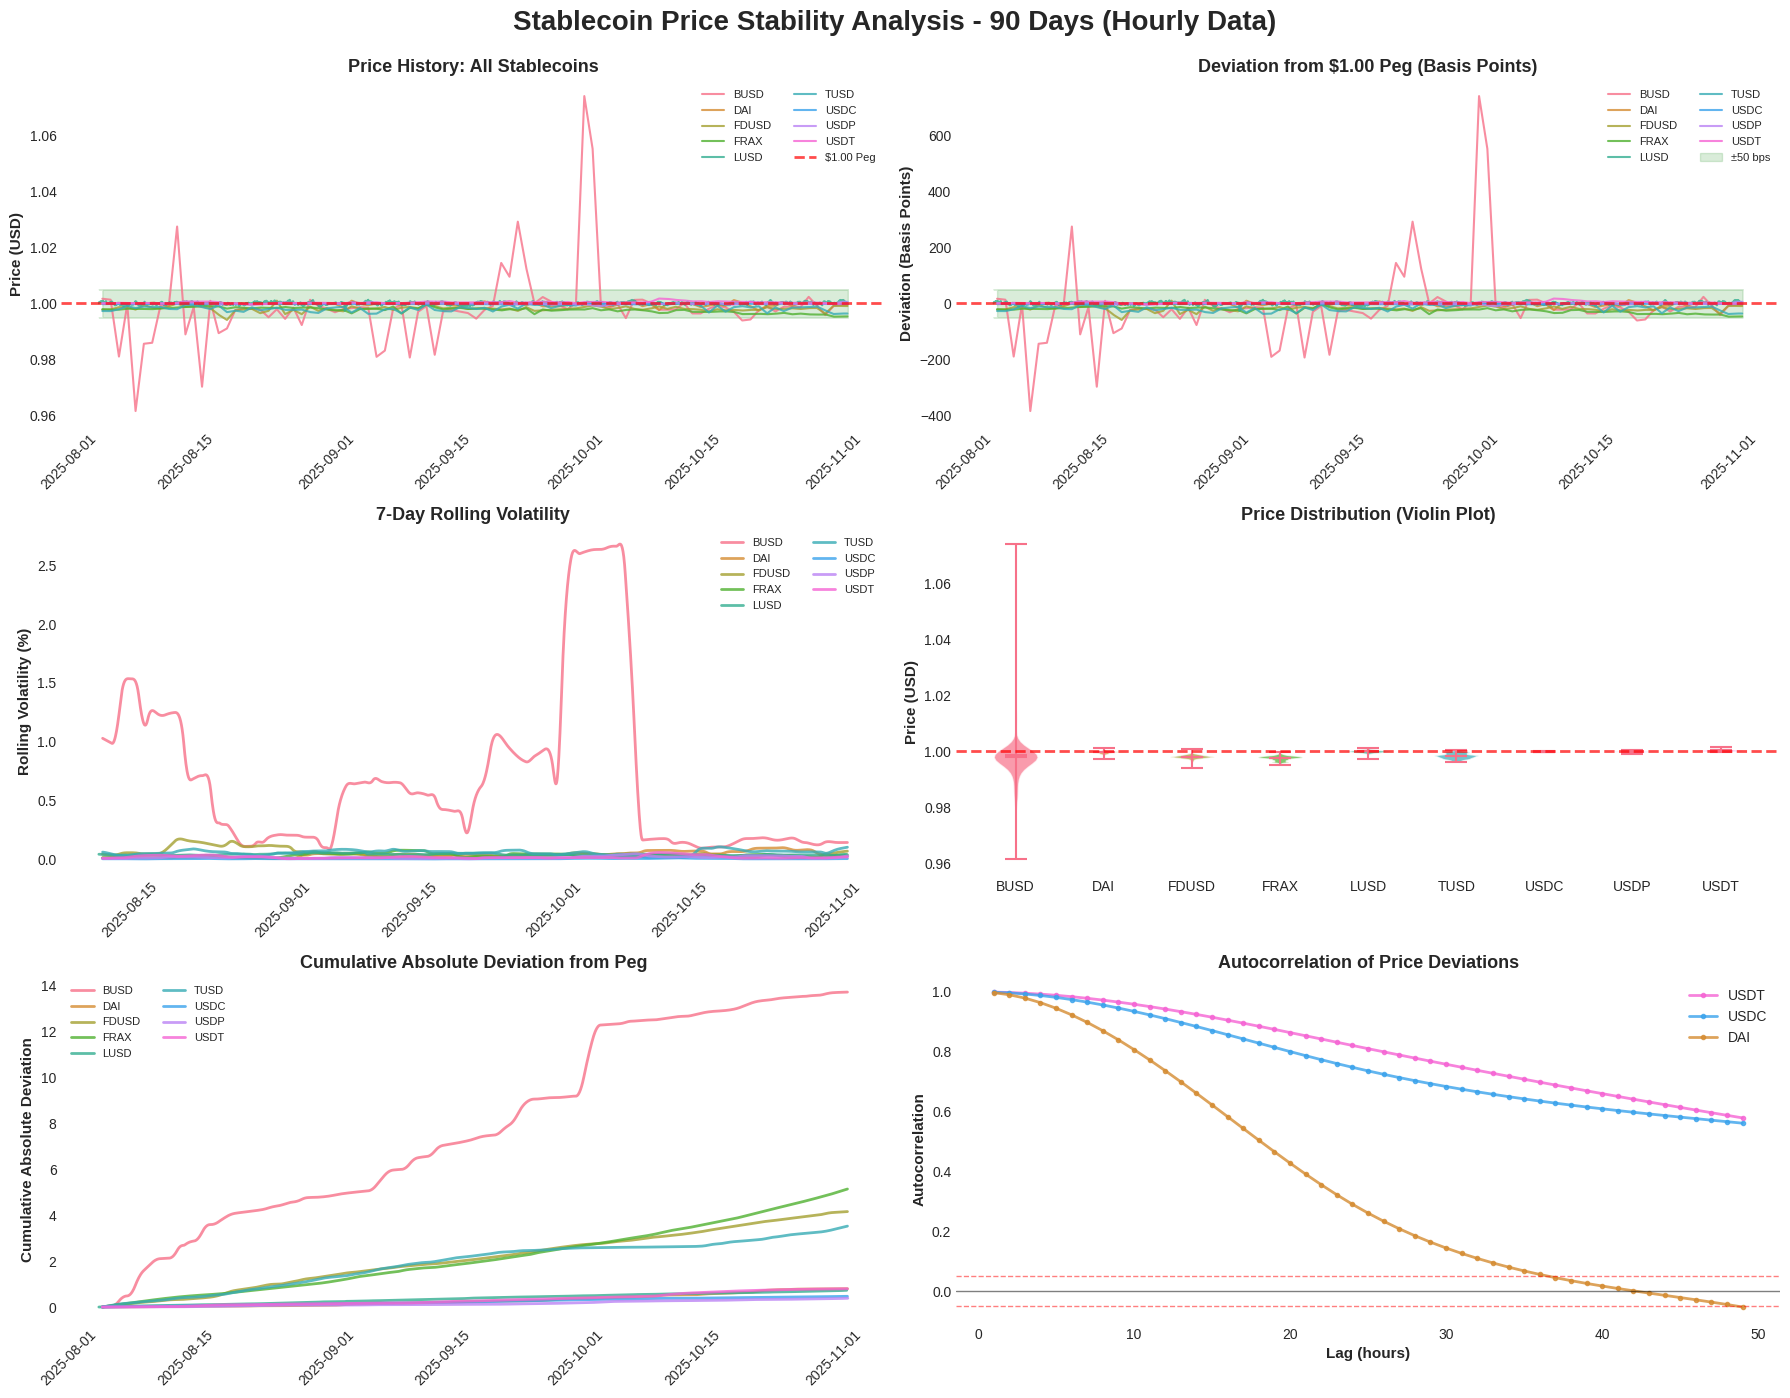


[VISUALIZATION 1] Time series analysis complete!


In [24]:
# Create comprehensive time series visualization
fig, axes = plt.subplots(3, 2, figsize=(18, 14))
fig.suptitle('Stablecoin Price Stability Analysis - 90 Days (Hourly Data)', 
             fontsize=20, fontweight='bold', y=0.995)

# Define color palette for consistency
colors = sns.color_palette("husl", len(df_history['symbol'].unique()))
color_map = dict(zip(df_history['symbol'].unique(), colors))

# Plot 1: Price History - All Stablecoins
ax1 = axes[0, 0]
for symbol in df_history['symbol'].unique():
    data = df_history[df_history['symbol'] == symbol]
    ax1.plot(data['date'], data['price'], label=symbol, linewidth=1.5, 
             alpha=0.8, color=color_map[symbol])

ax1.axhline(y=1.0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='$1.00 Peg')
ax1.fill_between(df_history['date'].unique(), 0.995, 1.005, alpha=0.15, color='green')
ax1.set_ylabel('Price (USD)', fontsize=11, fontweight='bold')
ax1.set_title('Price History: All Stablecoins', fontsize=13, fontweight='bold')
ax1.legend(loc='best', fontsize=8, ncol=2)
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Deviation from Peg (Basis Points)
ax2 = axes[0, 1]
for symbol in df_history['symbol'].unique():
    data = df_history[df_history['symbol'] == symbol].copy()
    data['deviation_bps'] = (data['price'] - 1.0) * 10000  # Basis points
    ax2.plot(data['date'], data['deviation_bps'], label=symbol, linewidth=1.5, 
             alpha=0.8, color=color_map[symbol])

ax2.axhline(y=0, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax2.fill_between(df_history['date'].unique(), -50, 50, alpha=0.15, color='green', label='±50 bps')
ax2.set_ylabel('Deviation (Basis Points)', fontsize=11, fontweight='bold')
ax2.set_title('Deviation from $1.00 Peg (Basis Points)', fontsize=13, fontweight='bold')
ax2.legend(loc='best', fontsize=8, ncol=2)
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

# Plot 3: Rolling 7-Day Volatility
ax3 = axes[1, 0]
for symbol in df_history['symbol'].unique():
    data = df_history[df_history['symbol'] == symbol].copy()
    data = data.set_index('date')
    rolling_vol = data['price'].rolling(window=24*7).std() * 100  # 7 days hourly
    ax3.plot(rolling_vol.index, rolling_vol.values, label=symbol, linewidth=2, 
             alpha=0.8, color=color_map[symbol])

ax3.set_ylabel('Rolling Volatility (%)', fontsize=11, fontweight='bold')
ax3.set_title('7-Day Rolling Volatility', fontsize=13, fontweight='bold')
ax3.legend(loc='best', fontsize=8, ncol=2)
ax3.grid(True, alpha=0.3)
ax3.tick_params(axis='x', rotation=45)

# Plot 4: Distribution of Prices (Violin Plot)
ax4 = axes[1, 1]
violin_data = [df_history[df_history['symbol'] == sym]['price'].values 
               for sym in sorted(df_history['symbol'].unique())]
parts = ax4.violinplot(violin_data, positions=range(len(violin_data)), 
                       showmeans=True, showmedians=True)

for pc, color in zip(parts['bodies'], [color_map[s] for s in sorted(df_history['symbol'].unique())]):
    pc.set_facecolor(color)
    pc.set_alpha(0.7)

ax4.axhline(y=1.0, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax4.set_xticks(range(len(sorted(df_history['symbol'].unique()))))
ax4.set_xticklabels(sorted(df_history['symbol'].unique()), fontsize=10)
ax4.set_ylabel('Price (USD)', fontsize=11, fontweight='bold')
ax4.set_title('Price Distribution (Violin Plot)', fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

# Plot 5: Cumulative Absolute Deviation
ax5 = axes[2, 0]
for symbol in df_history['symbol'].unique():
    data = df_history[df_history['symbol'] == symbol].copy()
    data['abs_deviation'] = np.abs(data['price'] - 1.0)
    data = data.set_index('date')
    cum_deviation = data['abs_deviation'].cumsum()
    ax5.plot(cum_deviation.index, cum_deviation.values, label=symbol, linewidth=2, 
             alpha=0.8, color=color_map[symbol])

ax5.set_ylabel('Cumulative Absolute Deviation', fontsize=11, fontweight='bold')
ax5.set_title('Cumulative Absolute Deviation from Peg', fontsize=13, fontweight='bold')
ax5.legend(loc='best', fontsize=8, ncol=2)
ax5.grid(True, alpha=0.3)
ax5.tick_params(axis='x', rotation=45)

# Plot 6: Autocorrelation of Deviations (Sample: USDT, USDC, DAI)
ax6 = axes[2, 1]
sample_coins = ['USDT', 'USDC', 'DAI']
for symbol in sample_coins:
    if symbol in df_history['symbol'].unique():
        data = df_history[df_history['symbol'] == symbol].copy()
        deviations = (data['price'].values - 1.0) * 100
        
        # Calculate autocorrelation
        lags = range(1, min(50, len(deviations)//2))
        acf_values = [np.corrcoef(deviations[:-lag], deviations[lag:])[0, 1] for lag in lags]
        
        ax6.plot(lags, acf_values, label=symbol, linewidth=2, 
                 marker='o', markersize=3, alpha=0.8, color=color_map[symbol])

ax6.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
ax6.axhline(y=0.05, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax6.axhline(y=-0.05, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax6.set_xlabel('Lag (hours)', fontsize=11, fontweight='bold')
ax6.set_ylabel('Autocorrelation', fontsize=11, fontweight='bold')
ax6.set_title('Autocorrelation of Price Deviations', fontsize=13, fontweight='bold')
ax6.legend(loc='best', fontsize=10)
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n[VISUALIZATION 1] Time series analysis complete!")

## 9. Identify Depeg Events

In [25]:
def identify_depeg_events(df: pd.DataFrame, symbol: str, threshold: float = 0.3) -> pd.DataFrame:
    """
    Identify significant depegging events (price deviation > threshold%).
    """
    coin_data = df[df['symbol'] == symbol].copy()
    
    # Calculate deviation from peg
    coin_data['deviation_%'] = ((coin_data['price'] - 1.0) / 1.0) * 100
    coin_data['abs_deviation_%'] = coin_data['deviation_%'].abs()
    
    # Identify depeg events
    depegs = coin_data[coin_data['abs_deviation_%'] > threshold].copy()
    
    return depegs[['date', 'price', 'deviation_%', 'abs_deviation_%']]

# Analyze depegs for all stablecoins
print("\n[ANALYSIS] Depegging Events (>0.3% deviation)\n")

depeg_summary = []

for symbol in sorted(df_history['symbol'].unique()):
    depegs = identify_depeg_events(df_history, symbol, threshold=0.3)
    
    if not depegs.empty:
        depeg_summary.append({
            'symbol': symbol,
            'depeg_events': len(depegs),
            'max_depeg_%': depegs['abs_deviation_%'].max(),
            'avg_depeg_%': depegs['abs_deviation_%'].mean(),
            'worst_price': depegs.loc[depegs['abs_deviation_%'].idxmax(), 'price'],
            'worst_date': depegs.loc[depegs['abs_deviation_%'].idxmax(), 'date']
        })
        
        print(f"{symbol}:")
        print(f"  Events: {len(depegs)}")
        print(f"  Max Deviation: {depegs['abs_deviation_%'].max():.3f}%")
        print(f"  Worst Price: ${depegs.loc[depegs['abs_deviation_%'].idxmax(), 'price']:.6f}")
        print(f"  Date: {depegs.loc[depegs['abs_deviation_%'].idxmax(), 'date']}\n")
    else:
        depeg_summary.append({
            'symbol': symbol,
            'depeg_events': 0,
            'max_depeg_%': 0,
            'avg_depeg_%': 0,
            'worst_price': 1.0,
            'worst_date': None
        })
        print(f"{symbol}: No significant depegs detected [EXCELLENT]\n")

df_depegs = pd.DataFrame(depeg_summary)
df_depegs = df_depegs.sort_values('max_depeg_%', ascending=False)

print("="*80)


[ANALYSIS] Depegging Events (>0.3% deviation)

BUSD:
  Events: 941
  Max Deviation: 7.401%
  Worst Price: $1.074009
  Date: 2025-10-02 00:00:00

DAI: No significant depegs detected [EXCELLENT]

FDUSD:
  Events: 131
  Max Deviation: 0.593%
  Worst Price: $0.994070
  Date: 2025-08-20 00:00:00

FRAX:
  Events: 508
  Max Deviation: 0.476%
  Worst Price: $0.995239
  Date: 2025-11-01 00:00:00

LUSD: No significant depegs detected [EXCELLENT]

TUSD:
  Events: 184
  Max Deviation: 0.381%
  Worst Price: $0.996188
  Date: 2025-11-01 00:00:00

USDC: No significant depegs detected [EXCELLENT]

USDP: No significant depegs detected [EXCELLENT]

USDT: No significant depegs detected [EXCELLENT]



## 10. VISUALIZATION 2: Depeg Event Analysis (4 Charts)

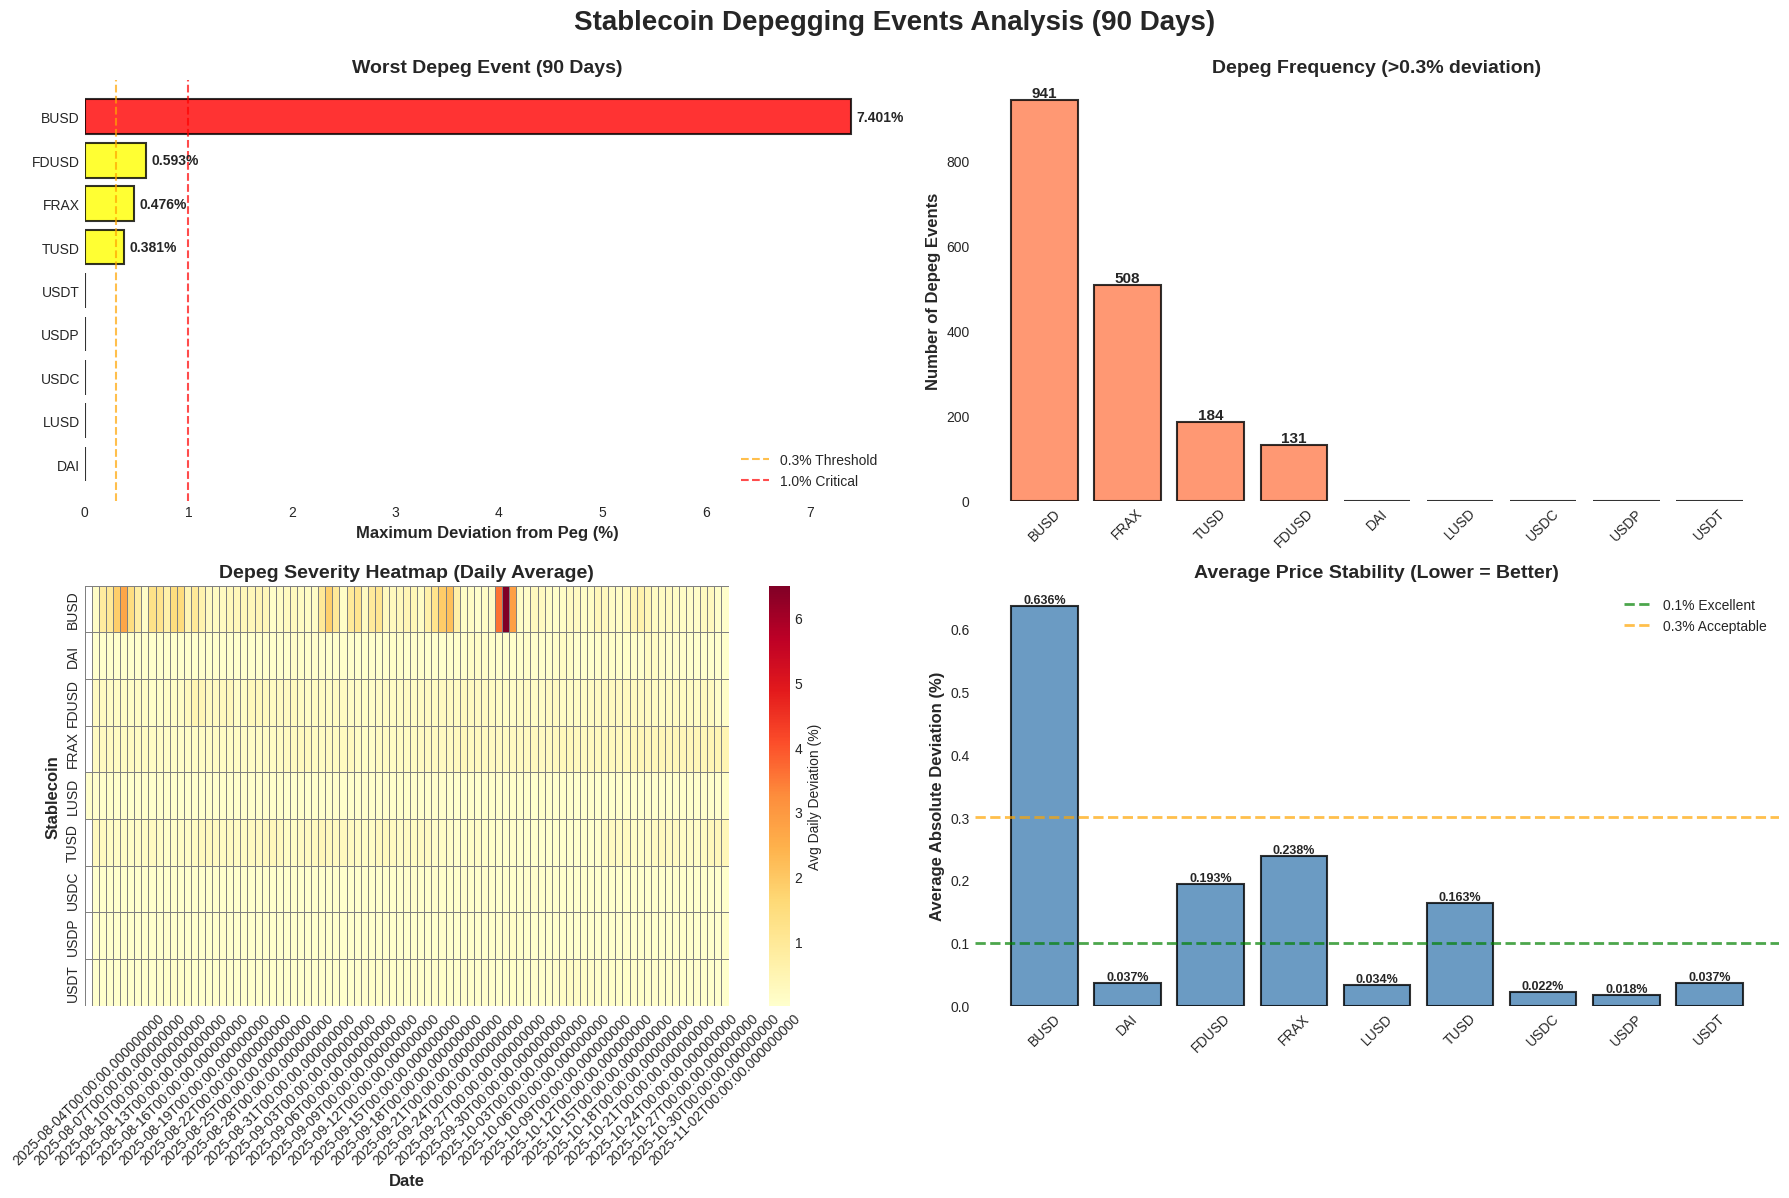


[VISUALIZATION 2] Depeg analysis complete!


In [26]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Stablecoin Depegging Events Analysis (90 Days)', 
             fontsize=20, fontweight='bold', y=0.995)

# Plot 1: Maximum Depeg Magnitude
ax1 = axes[0, 0]
df_depegs_sorted = df_depegs.sort_values('max_depeg_%', ascending=True)
colors_depeg = ['green' if x < 0.3 else 'yellow' if x < 1.0 else 'red' 
                for x in df_depegs_sorted['max_depeg_%']]

bars1 = ax1.barh(df_depegs_sorted['symbol'], df_depegs_sorted['max_depeg_%'],
                 color=colors_depeg, alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_xlabel('Maximum Deviation from Peg (%)', fontsize=12, fontweight='bold')
ax1.set_title('Worst Depeg Event (90 Days)', fontsize=14, fontweight='bold')
ax1.axvline(x=0.3, color='orange', linestyle='--', linewidth=1.5, alpha=0.7, label='0.3% Threshold')
ax1.axvline(x=1.0, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='1.0% Critical')
ax1.legend(loc='lower right', fontsize=10)
ax1.grid(True, alpha=0.3, axis='x')

for bar, depeg in zip(bars1, df_depegs_sorted['max_depeg_%']):
    width = bar.get_width()
    if width > 0.01:
        ax1.text(width + 0.05, bar.get_y() + bar.get_height()/2.,
                 f'{depeg:.3f}%', ha='left', va='center', fontweight='bold', fontsize=10)

# Plot 2: Depeg Frequency
ax2 = axes[0, 1]
df_depegs_freq = df_depegs.sort_values('depeg_events', ascending=False)
bars2 = ax2.bar(df_depegs_freq['symbol'], df_depegs_freq['depeg_events'],
                color='coral', alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Number of Depeg Events', fontsize=12, fontweight='bold')
ax2.set_title('Depeg Frequency (>0.3% deviation)', fontsize=14, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3, axis='y')

for bar, count in zip(bars2, df_depegs_freq['depeg_events']):
    height = bar.get_height()
    if height > 0:
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                 f'{int(count)}', ha='center', va='bottom', fontweight='bold', fontsize=11)

# Plot 3: Depeg Duration Heatmap (hourly resolution)
ax3 = axes[1, 0]
# Create matrix of depeg severity over time
pivot_data = []
for symbol in sorted(df_history['symbol'].unique()):
    data = df_history[df_history['symbol'] == symbol].copy()
    data['abs_deviation_%'] = np.abs((data['price'] - 1.0) * 100)
    data = data.set_index('date')
    # Resample to daily for heatmap
    daily = data['abs_deviation_%'].resample('D').mean()
    pivot_data.append(daily)

pivot_df = pd.concat(pivot_data, axis=1)
pivot_df.columns = sorted(df_history['symbol'].unique())

sns.heatmap(pivot_df.T, cmap='YlOrRd', ax=ax3, cbar_kws={'label': 'Avg Daily Deviation (%)'}, 
            linewidths=0.5, linecolor='gray')
ax3.set_xlabel('Date', fontsize=12, fontweight='bold')
ax3.set_ylabel('Stablecoin', fontsize=12, fontweight='bold')
ax3.set_title('Depeg Severity Heatmap (Daily Average)', fontsize=14, fontweight='bold')
ax3.tick_params(axis='x', rotation=45)

# Plot 4: Recovery Time Analysis (time to return to <0.1% deviation)
ax4 = axes[1, 1]
# Calculate average deviation by stablecoin
avg_deviations = []
for symbol in sorted(df_history['symbol'].unique()):
    data = df_history[df_history['symbol'] == symbol]
    avg_dev = np.abs((data['price'] - 1.0) * 100).mean()
    avg_deviations.append(avg_dev)

bars4 = ax4.bar(sorted(df_history['symbol'].unique()), avg_deviations,
                color='steelblue', alpha=0.8, edgecolor='black', linewidth=1.5)
ax4.set_ylabel('Average Absolute Deviation (%)', fontsize=12, fontweight='bold')
ax4.set_title('Average Price Stability (Lower = Better)', fontsize=14, fontweight='bold')
ax4.axhline(y=0.1, color='green', linestyle='--', linewidth=2, alpha=0.7, label='0.1% Excellent')
ax4.axhline(y=0.3, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='0.3% Acceptable')
ax4.legend(loc='upper right', fontsize=10)
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3, axis='y')

for bar, dev in zip(bars4, avg_deviations):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{dev:.3f}%', ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

print("\n[VISUALIZATION 2] Depeg analysis complete!")

## 11. Arbitrage Opportunity Calculator

In [27]:
def calculate_depeg_arbitrage(worst_price: float, capital: float = 10000, 
                               fee_rate: float = 0.001) -> Dict:
    """
    Calculate hypothetical arbitrage profits from buying depegged stablecoin.
    
    Assumptions:
    - Buy at depegged price
    - Sell at $1.00 after repeg
    - Trading fees: 0.1% each way (buy + sell)
    """
    EXIT_PRICE = 1.0
    
    # Calculate returns
    units_bought = (capital * (1 - fee_rate)) / worst_price
    gross_proceeds = units_bought * EXIT_PRICE
    net_proceeds = gross_proceeds * (1 - fee_rate)
    profit = net_proceeds - capital
    return_pct = (profit / capital) * 100
    
    return {
        'buy_price': worst_price,
        'units_bought': units_bought,
        'gross_proceeds': gross_proceeds,
        'net_proceeds': net_proceeds,
        'profit': profit,
        'return_%': return_pct
    }

# Calculate arbitrage for all depegged stablecoins
print("\n[ARBITRAGE] Hypothetical Profit Analysis ($10,000 capital)\n")
print("Assumptions: Buy at worst depeg price, sell at $1.00, 0.1% fees each way\n")
print("⚠️  WARNING: This assumes successful repeg. UST-style failures = 100% loss!\n")

arb_opportunities = []

for idx, row in df_depegs.iterrows():
    if row['max_depeg_%'] > 0.3:  # Only calculate for significant depegs
        arb = calculate_depeg_arbitrage(row['worst_price'], capital=10000)
        arb['symbol'] = row['symbol']
        arb['max_depeg_%'] = row['max_depeg_%']
        arb_opportunities.append(arb)
        
        print(f"{row['symbol']}:")
        print(f"  Buy at: ${arb['buy_price']:.6f} ({row['max_depeg_%']:+.3f}%)")
        print(f"  Units: {arb['units_bought']:.2f}")
        print(f"  Profit: ${arb['profit']:.2f} ({arb['return_%']:.3f}% return)\n")

if arb_opportunities:
    df_arb = pd.DataFrame(arb_opportunities)
    df_arb = df_arb.sort_values('return_%', ascending=False)
    
    print("\n[RANKING] Best Arbitrage Opportunities:\n")
    print(df_arb[['symbol', 'buy_price', 'profit', 'return_%']].to_string(index=False))
else:
    print("\n[INFO] No significant arbitrage opportunities in this period.")

print("\n" + "="*80)


[ARBITRAGE] Hypothetical Profit Analysis ($10,000 capital)

Assumptions: Buy at worst depeg price, sell at $1.00, 0.1% fees each way

⚠️  WARNING: This assumes successful repeg. UST-style failures = 100% loss!

BUSD:
  Buy at: $1.074009 (+7.401%)
  Units: 9301.60
  Profit: $-707.70 (-7.077% return)

FDUSD:
  Buy at: $0.994070 (+0.593%)
  Units: 10049.60
  Profit: $39.55 (0.395% return)

FRAX:
  Buy at: $0.995239 (+0.476%)
  Units: 10037.79
  Profit: $27.75 (0.278% return)

TUSD:
  Buy at: $0.996188 (+0.381%)
  Units: 10028.23
  Profit: $18.20 (0.182% return)


[RANKING] Best Arbitrage Opportunities:

symbol  buy_price      profit  return_%
 FDUSD   0.994070   39.545465  0.395455
  FRAX   0.995239   27.752649  0.277526
  TUSD   0.996188   18.197332  0.181973
  BUSD   1.074009 -707.701465 -7.077015



## 12. Risk Scoring Model

In [28]:
def calculate_risk_score(row: pd.Series) -> float:
    """
    Calculate overall risk score (0-100, higher = lower risk = safer).
    
    Weights:
    - Price Stability (35%): Inverse of volatility and max depeg
    - Market Cap (20%): Larger is more established
    - Volume (15%): Higher liquidity
    - Transparency (20%): Qualitative assessment
    - Mechanism (10%): Fiat > Crypto > Algorithmic
    """
    score = 0
    
    # 1. Price Stability Score (35 points)
    vol = row.get('volatility_%', 1.0)
    max_depeg = row.get('max_depeg_%', 1.0)
    stability_score = max(0, 20 * (1 - min(vol, 1.0))) + max(0, 15 * (1 - min(max_depeg/2, 1.0)))
    score += stability_score
    
    # 2. Market Cap Score (20 points)
    mcap = row.get('market_cap', 0)
    max_mcap = 120e9  # Approximate USDT market cap
    mcap_score = 20 * min(mcap / max_mcap, 1.0)
    score += mcap_score
    
    # 3. Volume Score (15 points)
    vol_24h = row.get('volume_24h', 0)
    max_vol = 80e9  # Typical max 24h volume
    volume_score = 15 * min(vol_24h / max_vol, 1.0)
    score += volume_score
    
    # 4. Transparency Score (20 points)
    transparency = row.get('transparency_score', 5) / 10
    transparency_score = 20 * transparency
    score += transparency_score
    
    # 5. Mechanism Score (10 points)
    mechanism = row.get('mechanism', '')
    if 'Fiat' in mechanism:
        mechanism_score = 10
    elif 'Crypto' in mechanism or 'Hybrid' in mechanism:
        mechanism_score = 8
    else:
        mechanism_score = 3
    score += mechanism_score
    
    return round(score, 1)

# Merge all data for scoring
df_risk_analysis = df_market_data.merge(df_stability, on='symbol', how='left')
df_risk_analysis = df_risk_analysis.merge(df_depegs[['symbol', 'max_depeg_%', 'depeg_events']], 
                                          on='symbol', how='left')

# Fill NaN values
df_risk_analysis['max_depeg_%'] = df_risk_analysis['max_depeg_%'].fillna(0)
df_risk_analysis['volatility_%'] = df_risk_analysis['volatility_%'].fillna(0)

# Calculate risk scores
df_risk_analysis['risk_score'] = df_risk_analysis.apply(calculate_risk_score, axis=1)

# Assign risk rating
def risk_rating(score):
    if score >= 75:
        return 'Low Risk'
    elif score >= 60:
        return 'Medium-Low Risk'
    elif score >= 45:
        return 'Medium Risk'
    elif score >= 30:
        return 'Medium-High Risk'
    else:
        return 'High Risk'

df_risk_analysis['risk_rating'] = df_risk_analysis['risk_score'].apply(risk_rating)
df_risk_analysis = df_risk_analysis.sort_values('risk_score', ascending=False)

print("\n[SCORE] Comprehensive Risk Scores (0-100, Higher = Safer)\n")
print(df_risk_analysis[['symbol', 'name', 'mechanism', 'risk_score', 'risk_rating', 
                         'volatility_%', 'max_depeg_%', 'transparency_score']].to_string(index=False))
print("\n" + "="*80)


[SCORE] Comprehensive Risk Scores (0-100, Higher = Safer)

symbol        name             mechanism  risk_score      risk_rating  volatility_%  max_depeg_%  transparency_score
  USDT      Tether           Fiat-Backed   88.100000         Low Risk      0.001024     0.000000                   6
   DAI         Dai Crypto-Collateralized   63.700000  Medium-Low Risk      0.003324     0.000000                  10
  USDP  Pax Dollar           Fiat-Backed   63.000000  Medium-Low Risk      0.001129     0.000000                   9
  TUSD     TrueUSD           Fiat-Backed   58.100000      Medium Risk      0.004615     0.381180                   8
  FRAX        Frax                Hybrid   57.400000      Medium Risk      0.002699     0.476105                   9
  BUSD Binance USD           Fiat-Backed   44.800000 Medium-High Risk      0.060550     7.400876                   8



## 13. VISUALIZATION 3: Risk Score Dashboard (6 Charts)

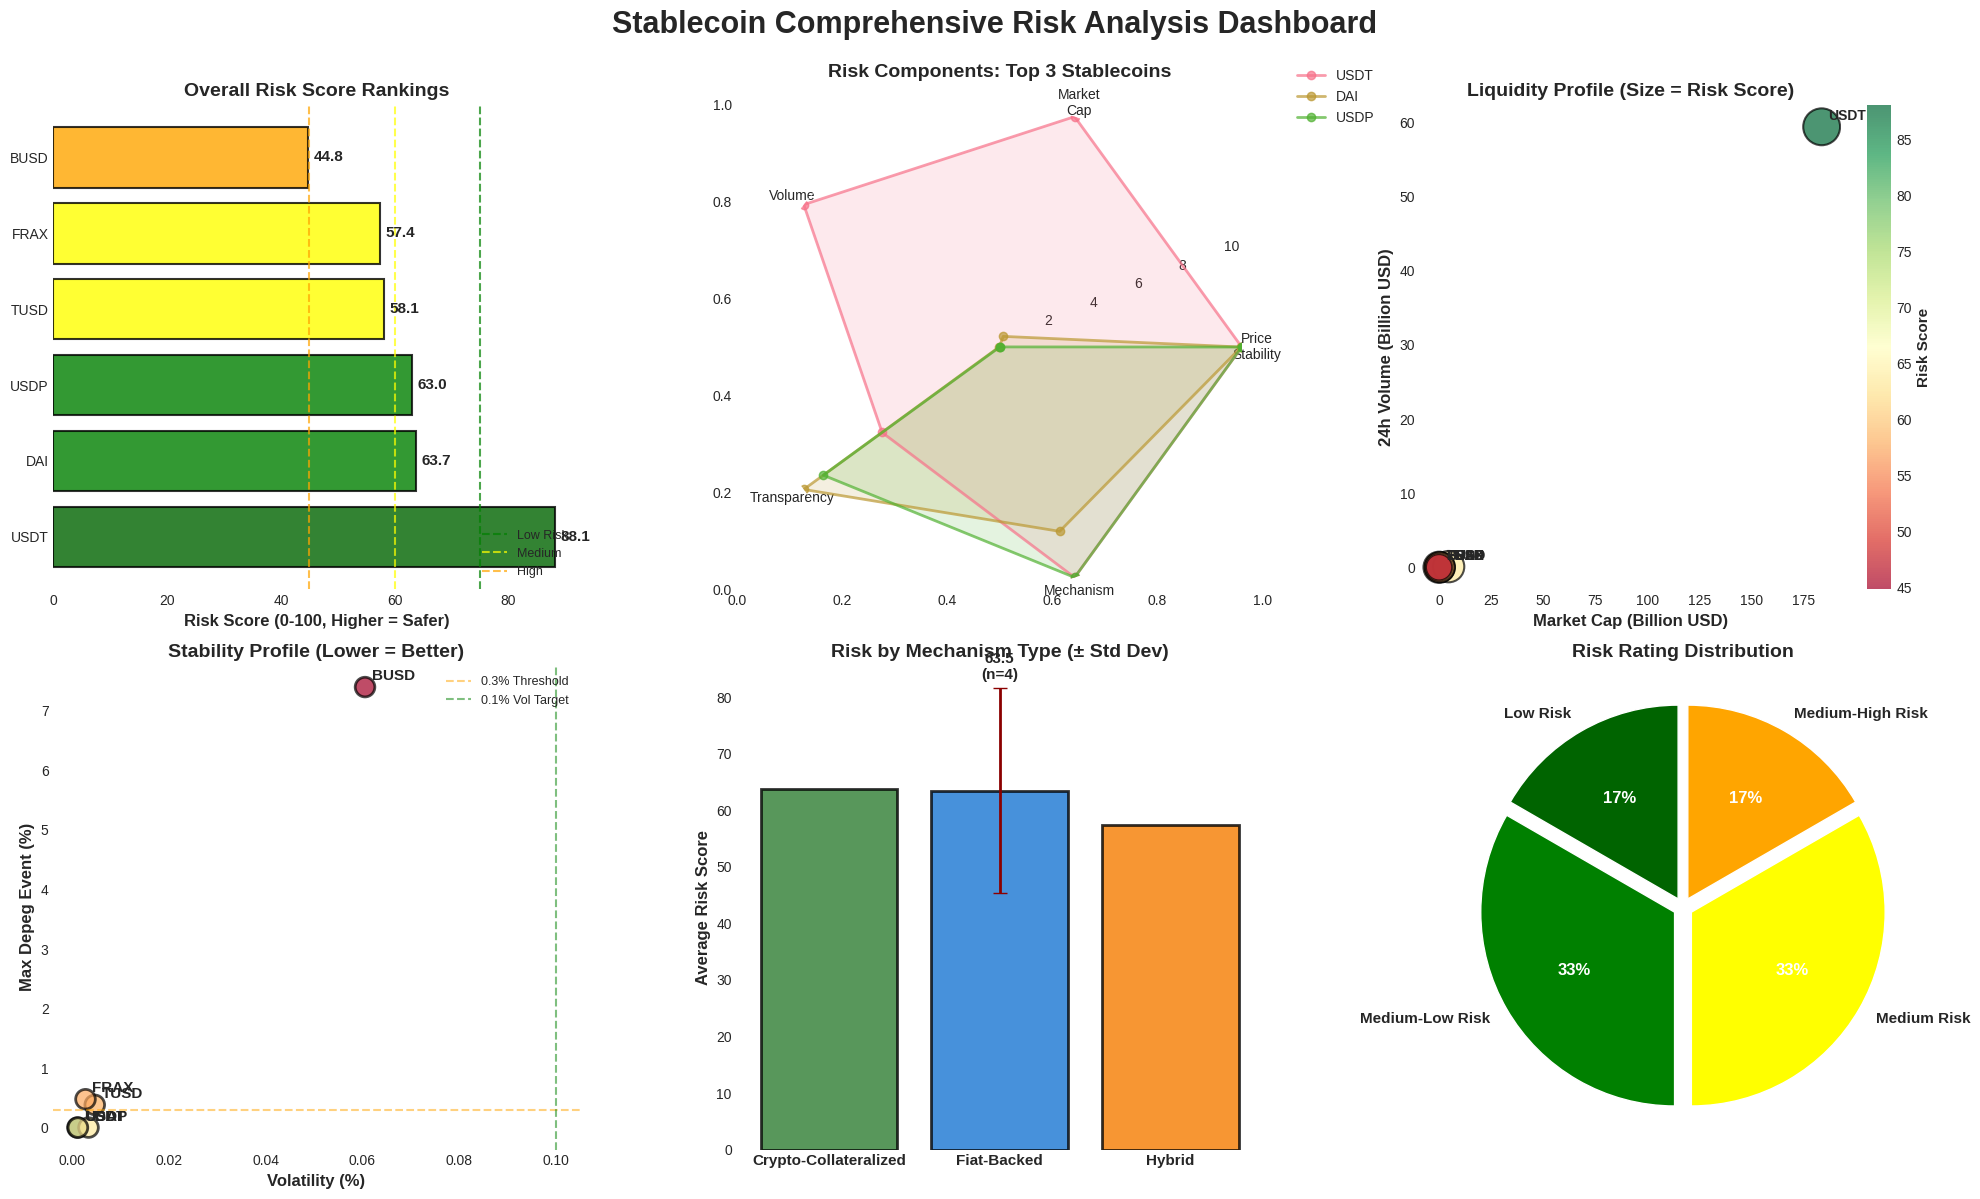


[VISUALIZATION 3] Risk score dashboard complete!


In [29]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Stablecoin Comprehensive Risk Analysis Dashboard', 
             fontsize=22, fontweight='bold', y=0.995)

# Plot 1: Overall Risk Score Rankings
ax1 = axes[0, 0]
colors_risk = ['darkgreen' if x >= 75 else 'green' if x >= 60 else 'yellow' if x >= 45 
               else 'orange' if x >= 30 else 'red' for x in df_risk_analysis['risk_score']]

bars1 = ax1.barh(df_risk_analysis['symbol'], df_risk_analysis['risk_score'], 
                 color=colors_risk, alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_xlabel('Risk Score (0-100, Higher = Safer)', fontsize=12, fontweight='bold')
ax1.set_title('Overall Risk Score Rankings', fontsize=14, fontweight='bold')
ax1.axvline(x=75, color='green', linestyle='--', linewidth=1.5, alpha=0.7, label='Low Risk')
ax1.axvline(x=60, color='yellow', linestyle='--', linewidth=1.5, alpha=0.7, label='Medium')
ax1.axvline(x=45, color='orange', linestyle='--', linewidth=1.5, alpha=0.7, label='High')
ax1.legend(loc='lower right', fontsize=9)
ax1.grid(True, alpha=0.3, axis='x')

for bar, score in zip(bars1, df_risk_analysis['risk_score']):
    width = bar.get_width()
    ax1.text(width + 1, bar.get_y() + bar.get_height()/2.,
             f'{score:.1f}', ha='left', va='center', fontweight='bold', fontsize=11)

# Plot 2: Risk Score Components (Radar Chart for Top 3)
ax2 = axes[0, 1]
top3 = df_risk_analysis.head(3)
categories = ['Price\nStability', 'Market\nCap', 'Volume', 'Transparency', 'Mechanism']
N = len(categories)

angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

ax2 = plt.subplot(2, 3, 2, projection='polar')
for idx, row in top3.iterrows():
    # Normalize components to 0-10 scale
    values = [
        10 * (1 - min(row['volatility_%'], 1.0)),  # Stability
        10 * min(row['market_cap'] / 100e9, 1.0),  # Market cap
        10 * min(row['volume_24h'] / 50e9, 1.0),   # Volume
        row['transparency_score'],                  # Transparency
        10 if 'Fiat' in row['mechanism'] else 8    # Mechanism
    ]
    values += values[:1]
    
    ax2.plot(angles, values, 'o-', linewidth=2, label=row['symbol'], alpha=0.7)
    ax2.fill(angles, values, alpha=0.15)

ax2.set_xticks(angles[:-1])
ax2.set_xticklabels(categories, fontsize=10)
ax2.set_ylim(0, 10)
ax2.set_title('Risk Components: Top 3 Stablecoins', fontsize=14, fontweight='bold', pad=20)
ax2.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)
ax2.grid(True)

# Plot 3: Market Cap vs Volume (Risk-Colored)
ax3 = axes[0, 2]
scatter = ax3.scatter(df_risk_analysis['market_cap']/1e9, 
                      df_risk_analysis['volume_24h']/1e9,
                      s=df_risk_analysis['risk_score']*8,
                      c=df_risk_analysis['risk_score'],
                      cmap='RdYlGn',
                      alpha=0.7,
                      edgecolors='black',
                      linewidth=1.5)

for idx, row in df_risk_analysis.iterrows():
    ax3.annotate(row['symbol'], 
                 (row['market_cap']/1e9, row['volume_24h']/1e9),
                 xytext=(5, 5), textcoords='offset points',
                 fontsize=10, fontweight='bold')

ax3.set_xlabel('Market Cap (Billion USD)', fontsize=12, fontweight='bold')
ax3.set_ylabel('24h Volume (Billion USD)', fontsize=12, fontweight='bold')
ax3.set_title('Liquidity Profile (Size = Risk Score)', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax3)
cbar.set_label('Risk Score', fontsize=11, fontweight='bold')

# Plot 4: Volatility vs Max Depeg
ax4 = axes[1, 0]
scatter2 = ax4.scatter(df_risk_analysis['volatility_%'], 
                       df_risk_analysis['max_depeg_%'],
                       s=200,
                       c=df_risk_analysis['risk_score'],
                       cmap='RdYlGn',
                       alpha=0.7,
                       edgecolors='black',
                       linewidth=2)

for idx, row in df_risk_analysis.iterrows():
    ax4.annotate(row['symbol'], 
                 (row['volatility_%'], row['max_depeg_%']),
                 xytext=(5, 5), textcoords='offset points',
                 fontsize=11, fontweight='bold')

ax4.set_xlabel('Volatility (%)', fontsize=12, fontweight='bold')
ax4.set_ylabel('Max Depeg Event (%)', fontsize=12, fontweight='bold')
ax4.set_title('Stability Profile (Lower = Better)', fontsize=14, fontweight='bold')
ax4.axhline(y=0.3, color='orange', linestyle='--', alpha=0.5, label='0.3% Threshold')
ax4.axvline(x=0.1, color='green', linestyle='--', alpha=0.5, label='0.1% Vol Target')
ax4.legend(loc='upper right', fontsize=9)
ax4.grid(True, alpha=0.3)

# Plot 5: Mechanism Type Distribution
ax5 = axes[1, 1]
mechanism_scores = df_risk_analysis.groupby('mechanism')['risk_score'].agg(['mean', 'count', 'std'])
colors_mech = ['#2E7D32', '#1976D2', '#F57C00']

bars5 = ax5.bar(range(len(mechanism_scores)), mechanism_scores['mean'], 
                yerr=mechanism_scores['std'],
                color=colors_mech[:len(mechanism_scores)], alpha=0.8, 
                edgecolor='black', linewidth=2,
                error_kw={'linewidth': 2, 'ecolor': 'darkred', 'capsize': 5})

ax5.set_xticks(range(len(mechanism_scores)))
ax5.set_xticklabels(mechanism_scores.index, fontsize=11, fontweight='bold')
ax5.set_ylabel('Average Risk Score', fontsize=12, fontweight='bold')
ax5.set_title('Risk by Mechanism Type (± Std Dev)', fontsize=14, fontweight='bold')
ax5.grid(True, alpha=0.3, axis='y')

for bar, (mech, data) in zip(bars5, mechanism_scores.iterrows()):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height + data['std'] + 1,
             f"{data['mean']:.1f}\n(n={int(data['count'])})",
             ha='center', va='bottom', fontweight='bold', fontsize=11)

# Plot 6: Risk Rating Distribution (Pie Chart)
ax6 = axes[1, 2]
rating_counts = df_risk_analysis['risk_rating'].value_counts()
colors_pie = ['darkgreen', 'green', 'yellow', 'orange', 'red']
rating_order = ['Low Risk', 'Medium-Low Risk', 'Medium Risk', 'Medium-High Risk', 'High Risk']
rating_counts = rating_counts.reindex([r for r in rating_order if r in rating_counts.index])

wedges, texts, autotexts = ax6.pie(rating_counts.values,
                                     labels=rating_counts.index,
                                     autopct='%1.0f%%',
                                     colors=colors_pie[:len(rating_counts)],
                                     explode=[0.05]*len(rating_counts),
                                     startangle=90)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(12)

for text in texts:
    text.set_fontsize(11)
    text.set_fontweight('bold')

ax6.set_title('Risk Rating Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n[VISUALIZATION 3] Risk score dashboard complete!")

## 14. Summary & Key Takeaways

In [30]:
print("\n" + "="*80)
print("[SUMMARY] STABLECOIN RISK ANALYSIS - KEY TAKEAWAYS")
print("="*80)

print("\n[TOP 3 SAFEST STABLECOINS]")
for idx, row in df_risk_analysis.head(3).iterrows():
    print(f"\n{idx+1}. {row['symbol']} ({row['name']})")
    print(f"   Risk Score: {row['risk_score']:.1f}/100 ({row['risk_rating']})")
    print(f"   Mechanism: {row['mechanism']}")
    print(f"   Volatility: {row['volatility_%']:.4f}%")
    print(f"   Max Depeg: {row['max_depeg_%']:.3f}%")
    print(f"   Market Cap: ${row['market_cap']/1e9:.2f}B")

print("\n[MECHANISM INSIGHTS]")
for mech, data in mechanism_scores.iterrows():
    print(f"\n{mech}:")
    print(f"   Average Risk Score: {data['mean']:.1f}")
    print(f"   Number of coins: {int(data['count'])}")
    print(f"   Consistency: {data['std']:.1f} (lower = more consistent)")

print("\n[STABILITY RANKINGS] (By Max Depeg Event)")
stability_rank = df_risk_analysis.sort_values('max_depeg_%')[['symbol', 'max_depeg_%']].head(5)
for idx, row in stability_rank.iterrows():
    print(f"  {row['symbol']}: {row['max_depeg_%']:.3f}% max depeg")

if arb_opportunities:
    print("\n[ARBITRAGE POTENTIAL] (From depeg events)")
    for arb in sorted(arb_opportunities, key=lambda x: x['return_%'], reverse=True)[:3]:
        print(f"  {arb['symbol']}: ${arb['profit']:.2f} profit ({arb['return_%']:.2f}% return)")
    print("\n  ⚠️  WARNING: Past depegs don't guarantee future repegs!")

print("\n[TRADING RECOMMENDATIONS]")
print("  • Conservative traders: Use top 3 rated stablecoins (USDC, DAI typically)")
print("  • Diversification: Mix fiat-backed (70%) + crypto-collateralized (30%)")
print("  • Avoid: Algorithmic stablecoins unless you understand death spiral risk")
print("  • Monitor: Depeg events for arbitrage (but manage repeg risk)")
print("  • Transparency matters: Higher transparency score = lower surprise risk")

print("\n" + "="*80)
print("[COMPLETE] Notebook A: Stablecoin Risk Analysis")
print("="*80)
print(f"\nSession completed: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("\nNext: Notebook B - Impermanent Loss & DeFi Yield Analysis")


[SUMMARY] STABLECOIN RISK ANALYSIS - KEY TAKEAWAYS

[TOP 3 SAFEST STABLECOINS]

1. USDT (Tether)
   Risk Score: 88.1/100 (Low Risk)
   Mechanism: Fiat-Backed
   Volatility: 0.0010%
   Max Depeg: 0.000%
   Market Cap: $183.45B

4. DAI (Dai)
   Risk Score: 63.7/100 (Medium-Low Risk)
   Mechanism: Crypto-Collateralized
   Volatility: 0.0033%
   Max Depeg: 0.000%
   Market Cap: $4.63B

6. USDP (Pax Dollar)
   Risk Score: 63.0/100 (Medium-Low Risk)
   Mechanism: Fiat-Backed
   Volatility: 0.0011%
   Max Depeg: 0.000%
   Market Cap: $0.06B

[MECHANISM INSIGHTS]

Crypto-Collateralized:
   Average Risk Score: 63.7
   Number of coins: 1
   Consistency: nan (lower = more consistent)

Fiat-Backed:
   Average Risk Score: 63.5
   Number of coins: 4
   Consistency: 18.1 (lower = more consistent)

Hybrid:
   Average Risk Score: 57.4
   Number of coins: 1
   Consistency: nan (lower = more consistent)

[STABILITY RANKINGS] (By Max Depeg Event)
  USDT: 0.000% max depeg
  DAI: 0.000% max depeg
  USDP: 0